<a href="https://colab.research.google.com/github/kevinhhl/options-pricing-tools-and-trading-strategies/blob/main/Black_Scholes_Merton_Model_Part1_Screening_YF_for_theoretical_edges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahoo_fin
!pip install yfinance

In [2]:
import math
import time
import pandas as pd
from datetime import date
from scipy.stats import norm
from yahoo_fin import options
import yfinance as yf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# **Overview**

This script will allow us to obtain option chains provided by Yahoo Finance. We will go through the options one by one and apply the Black Scholes Model ("BSM") to calculate the theoretical values and Greeks. 

**Advantages to BSM:**
* It is widely used
* It's simple to apply

**Disadvantages to BSM:** 
* Was modeled for European-style options; early-exercise is not allowed
* Assumes price to follow a random walk according to a brownian motion with a constant drift. <br>(I have created a separate notebook to explore this topic. [<Link\>](https://github.com/kevinhhl/portfolio-management-tools/blob/main/Monte_Carlo_Simulation_Random_Walk.ipynb))
* Ignores dividends
* Taxes and transaction costs are ignored
* Inputs can be subjective, especially for expected volatility

##**Understanding the Model:**

Derivation of the BSM is complex. Through research [1], I'm using my own words to summarize how I understand it from a practical perspective.

The premise of the Black-Scholes Model contains two components. It can be described as taking the difference of: <br>
* (a) the expected value of a stock in the event that it reaches above/below exercise price on the date of expiration for call/put options, respectively, and 
* (b) the expected payout at the exercise price

<br>

These components are expressed as:
<br>\begin{equation}
TV_{call}=se^{rt}N(d_{1})-xN(d_{2})
\end{equation}
<br>\begin{equation}
TV_{put}=xe^{-rt}N(-d_{2})-sN(-d_{1})
\end{equation}

**Where**:
* TV is the theoretical value
* s is the spot price at the current moment
* x is the exercise price of the option
* t is the time till maturity in no. of years
* r is the risk free rate per annum
* σ is the annualized volatility
* N(d) is the CDF of a normal distribution.
<br>
<br>\begin{equation}
d_{1} =\frac{ln(\frac{S}{X})+(r+\frac{\sigma}{2}^2)t}{\sigma\sqrt{t}}
\end{equation}
<br>\begin{equation}
d_{2}=d_{1}-\sigma\sqrt{t}
\end{equation}



*Further contemplations:*

* The probability of price to be in-the-money for call/put options can be pictured as if seeing '*d*' landing in the right/left sides of the CDF (for call/put options, respectively).

* Probability of the put option to be in-the-money would be N(-d), representing the left tail of the CDF, which is the area from negative-infinity to zero minus *d*. The probability of a call option to be in-the-money would be 1-N(-d); the right-tail of the CDF.

* Price is not normally distributed. Instead, a lognormal distribution would better describe it. We still want to associate probability of price reaching X with the normal distribution, so we need to make the adjustments to *d*. Also, we will want to risk-adjust *d* according to *r*


##**The Greeks**
* Delta is the change of option's theoretical value with respect to price of the underlying asset
* Gamma is the change of Delta with respect to price of the underlying asset
* Theta is time decay, options from buyer's perspective, loses value as time approaches the maturity date. 
* Vega is the sensitivity of the option's theoretical value to a change in volatility 
* Rho, being the least popular Greek measurement among the above, is the sensitivity of the option’s theoretical value with respect to change of interest rate. Usually interest rate does not vary during the life of the option, and if it does, the changes are in small increments, thus the effect gets overshadowed by other Greek measurements we have introduced above. 

<br>

---
*References:*

[1] Natenberg, Sheldon. <i>Chapter 18, Option Volatility and Pricing, Second Edition</i>. McGraw-Hill Edu., 2015.

# **Implementation**

#### class BSM()

In [3]:
class BSM:
  
  def __init__(self, s,t,r,sigma):

    # Fixed variables, will not change as we iterate through the option chain
    self.s = s
    self.t = t
    self.r = r
    self.sigma = sigma

    # variables that will change as we iterate through the option chain
    self.x, self.d1, self.d2 = None, None, None
    self.tv_call, self.delta_call , self.gamma_call, self.vega_call, self.theta_call, self.rho_call = None, None, None, None, None, None
    self.tv_put, self.delta_put, self.gamma_put, self.vega_put, self.theta_put, self.rho_put = None, None, None, None, None, None

  def _recalc(self):
    # _recalc() needs to be called everytime when an input variable is changed
    _a = math.log(self.s/ self.x)
    _b = (self.r+self.sigma**2/2)*self.t
    self.d1 = (_a+_b)/self.sigma*math.sqrt(self.t)
    self.d2 = self.d1 - self.sigma * math.sqrt(self.t)
    
    # Call: TV, delta, gamma, vega, theta, rho
    self.tv_call = self.s * norm.cdf(self.d1) - self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2)
    self.delta_call = norm.cdf(self.d1)
    self.gamma_call = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_call = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_call = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) - self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    self.rho_call = 0.01*(self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    
    # Put: TV, delta, gamma, vega, theta, rho
    self.tv_put = self.x * math.exp(-self.r*self.t)-self.s+self.tv_call
    self.delta_put = -norm.cdf(-self.d1)
    self.gamma_put = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_put = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_put = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) + self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(-self.d2))
    self.rho_put = 0.01*(-self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(-self.d2))

  def set_x(self, x):
    self.x = x
    self._recalc()


#### static method: get_df()

In [4]:
NAME_STRIKE  = "Strike"       # Column names, declaring as variables to make it easier for re-naming
NAME_QUOTE   = "Quote"
NAME_TV      = "Th.Value"
NAME_TVDIFF  = "Th.Edge"
NAME_DELTA   = "Δ"
NAME_GAMMA   = "𝚪"
NAME_VEGA    = "V"
NAME_THETA   = "Θ"
NAME_RHO     = "⍴"

FORMAT_COLS = [NAME_STRIKE, NAME_QUOTE, NAME_TV, NAME_TVDIFF, NAME_DELTA, NAME_GAMMA, NAME_VEGA, NAME_THETA, NAME_RHO]

def get_df(original_chain, option_type, date_expire_str, verbose=False):
  ''' Returns a modified options chain (with custom columns showing the Greeks) based on original chain provided by Yahoo.
      @param Object original_chain : from options.get_options_chain(symbol, date_expire_str)["option_type"] 
      @param string option_type : either "calls" or "puts"
      @param string date_expire_str : element of options.get_expiration_dates(symbol)
  '''
  l_strike, l_quote, l_tv, l_diff, l_delta, l_gamma, l_vega, l_theta, l_rho, l_index_names = [], [], [], [], [], [], [], [], [], []

  for i in range(len(original_chain)):
    x = original_chain["Strike"][i]
    model.set_x(x)    
    
    tv, gamma, theta, vega, theta, rho = None, None, None, None, None, None
    if option_type == "calls":
      tv = model.tv_call
      delta, gamma, vega, theta, rho = model.delta_call, model.gamma_call, model.vega_call, model.theta_call, model.rho_call
    elif option_type == "puts":
      tv = model.tv_put
      delta, gamma, vega, theta, rho = model.delta_put, model.gamma_put, model.vega_put, model.theta_put, model.rho_put
      
    q = original_chain["Last Price"][i]
    _diff = (tv-q).round(2)
    if verbose:
      print("{}: strike= {}\tquote= {}\tTV= {};\tdiff.= {}".format(option_type, x, q, tv.round(2), _diff ))

    l_index_names.append("{}_{}_{}".format(date_expire_str, x, option_type))
    l_delta.append(delta.round(4))
    l_gamma.append(gamma.round(4))
    l_theta.append(theta.round(4))
    l_vega.append(vega.round(4))
    l_rho.append(rho.round(4))
    l_tv.append(tv.round(2))
    l_diff.append(_diff)
    l_strike.append(x)
    l_quote.append(q)

  return pd.DataFrame({ NAME_STRIKE:l_strike, NAME_QUOTE:l_quote, NAME_TV:l_tv, NAME_TVDIFF:l_diff, \
                       NAME_DELTA:l_delta, NAME_GAMMA:l_gamma, NAME_VEGA:l_vega, NAME_THETA:l_theta, \
                       NAME_RHO:l_rho }, columns=FORMAT_COLS, index=l_index_names)

#### Validations:


Comparing results with @YuChenAmberLu's implementation [<link\>](https://github.com/YuChenAmberLu/Options-Calculator)


In [5]:
# Expecting the results to be identical, if differences (rounded by 5 decimal places) match, then it's correct. 

test_model = BSM(s=100,t=0.128767,r=0.2,sigma=0.2)
test_model.set_x(100)

assert (test_model.tv_call    -   4.112199).round(5)==0
assert (test_model.delta_call -   .520269).round(5)==0
assert (test_model.gamma_call -   .055516).round(5)==0
assert (test_model.vega_call  -   .142972).round(5)==0
assert (test_model.theta_call -   -.206861).round(5)==0
assert (test_model.rho_call   -   .061698).round(5)==0
assert (test_model.tv_put     -   1.569736).round(5)==0
assert (test_model.delta_put  -   -.479731).round(5)==0
assert (test_model.gamma_put  -   .055516).round(5)==0
assert (test_model.vega_put   -   .142972).round(5)==0
assert (test_model.theta_put  -   -.011946).round(5)==0
assert (test_model.rho_put    -   -.063795).round(5)==0

# 😎 Application

😎 emoji = Requires user's attention.  

In [6]:
# 😎 Manual inputs:
symbol            = "TSLA"
riskfree_rate     = .0512
sigma             = 0.7
date_today        = date(2023,2,21)
date_expire       = date(2023,3,10)

In [7]:
# Confirming that the expiration date is valid.
exp_dates = options.get_expiration_dates(symbol)
date_expire_str = date_expire.strftime("%B %d, %Y") 
exp_dates

['February 24, 2023',
 'March 3, 2023',
 'March 10, 2023',
 'March 17, 2023',
 'March 24, 2023',
 'March 31, 2023',
 'April 21, 2023',
 'May 19, 2023',
 'June 16, 2023',
 'July 21, 2023',
 'September 15, 2023',
 'December 15, 2023',
 'January 19, 2024',
 'March 15, 2024',
 'June 21, 2024',
 'September 20, 2024',
 'January 17, 2025',
 'June 20, 2025']

In [8]:
assert date_expire_str in exp_dates

In [9]:
ticker_yahoo = yf.Ticker(symbol)
price_data = ticker_yahoo.history(period="3y")
crnt_price = price_data['Close'].iloc[-1]
crnt_price

197.3699951171875

In [10]:
model = BSM(s     = crnt_price,
            t     = (date_expire-date_today).days/365,
            r     = riskfree_rate,
            sigma = sigma )

In [11]:
original_chain_calls = options.get_options_chain(symbol, date_expire_str)["calls"]
original_chain_puts = options.get_options_chain(symbol, date_expire_str)["puts"]

df_call = get_df(original_chain_calls, "calls", date_expire_str)
df_put = get_df(original_chain_puts, "puts", date_expire_str)

##Screening criteria

Filter criteria:

* **1)** Only include strike prices that are near-the-money (or witin a "reasonable range" but deviating from at-the-money)

* **2)** Sort by theoretical edge 



### Monte carlo simulations -> Price

Obtaining a reasonable range of price.

mean=0.0016805686609954523, var=0.002006895230595036, drift=0.0006771210456979343


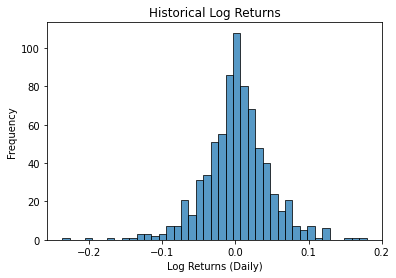

In [12]:
n_iters = 10000 # No. of iterations

price_data = price_data["Close"]
pc = np.log(1+price_data.pct_change()) 
pc
sb.histplot(pc.iloc[1:])
plt.title("Historical Log Returns")
plt.xlabel("Log Returns (Daily)")
plt.ylabel("Frequency");

mean = pc.mean()
var = pc.var()
stddev = pc.std()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))

In [13]:
date_t0 = date_today
date_tn = date_expire

n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
_t0 = date_t0         # tmp var.
while _t0 <= date_tn:
  n_forecast += 1
  _t0 += BDay(1)

<ipython-input-13-164a494aa297>:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:



TSLA
Shape=(14, 10000)
Simulation: From 2023-02-21 to 2023-03-10; Business days=13


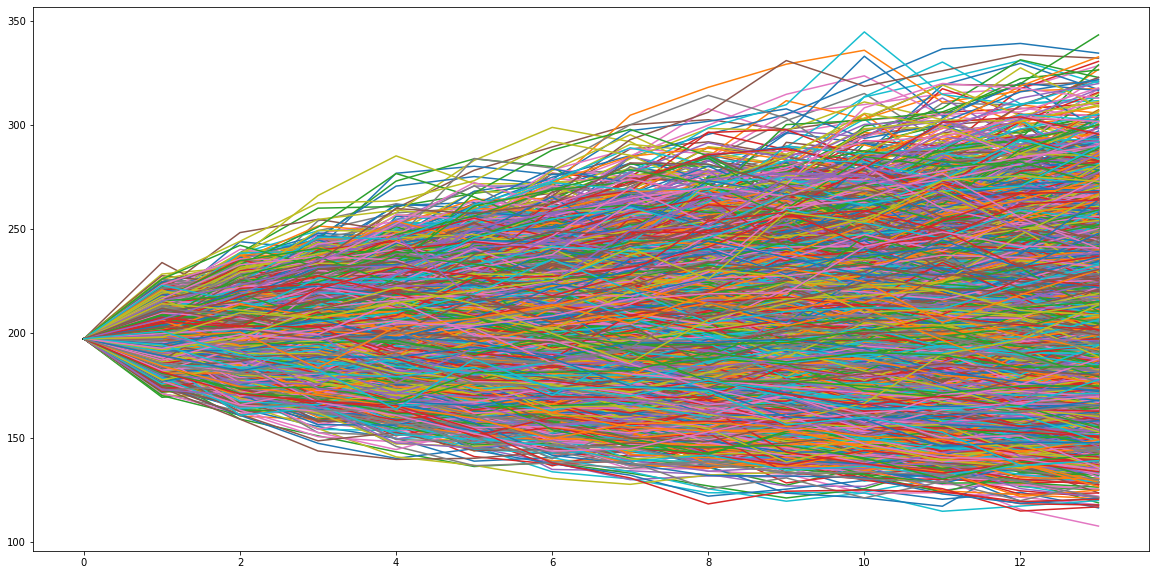

In [14]:
# Init. array[n_forecast][n_iters] of zeros 
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
sim_equity_curve = np.zeros_like(rand_returns)

# Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
sim_equity_curve[0] = price_data[len(price_data)-1]

# Perform random walk and plot
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]

assert(sim_equity_curve.shape==rand_returns.shape)
print("\n{}\nShape={}".format(symbol, sim_equity_curve.shape))
print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn))) 

plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

In [15]:
count = 0
stdev_multi = 2
print("{}\nt+n; \t\t\t\tstd \t\tmean \t\tmean - {}*std \t\tmean + {}*std \n".format(symbol, stdev_multi,stdev_multi)) 

for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  lower_bound = (mean-stdev_multi*std).round(2)
  upper_bound = (mean+stdev_multi*std).round(2)
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}"\
        .format(count, date_t0+BDay(count), std.round(2), mean.round(2), lower_bound, upper_bound))
  count += 1

print("\nStike prices should be between: {} to {}".format(lower_bound, upper_bound))

TSLA
t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-02-21 00:00:00 	std = 0.0 	mean = 197.37 	lower = 197.37 		upper = 197.37
t+1 	2023-02-22 00:00:00 	std = 8.84 	mean = 197.54 	lower = 179.85 		upper = 215.22
t+2 	2023-02-23 00:00:00 	std = 12.47 	mean = 197.83 	lower = 172.89 		upper = 222.78
t+3 	2023-02-24 00:00:00 	std = 15.36 	mean = 198.06 	lower = 167.34 		upper = 228.77
t+4 	2023-02-27 00:00:00 	std = 17.94 	mean = 198.52 	lower = 162.64 		upper = 234.4
t+5 	2023-02-28 00:00:00 	std = 20.02 	mean = 198.92 	lower = 158.87 		upper = 238.96
t+6 	2023-03-01 00:00:00 	std = 21.95 	mean = 199.21 	lower = 155.31 		upper = 243.11
t+7 	2023-03-02 00:00:00 	std = 23.79 	mean = 199.59 	lower = 152.02 		upper = 247.17
t+8 	2023-03-03 00:00:00 	std = 25.45 	mean = 199.88 	lower = 148.98 		upper = 250.79
t+9 	2023-03-06 00:00:00 	std = 26.98 	mean = 200.24 	lower = 146.28 		upper = 254.2
t+10 	2023-03-07 00:00:00 	std = 28.56 	mean = 200.49 	lower = 143.37 		upper = 257.6
t+

In [16]:
def get_df_filtered(custom_df):
  return (custom_df[(custom_df["Strike"]>=lower_bound) & (custom_df["Strike"]<=upper_bound)]).sort_values(by=["Th.Edge"],ascending=False)

### 😎 [Calls] filtered dataframe:

In [17]:
get_df_filtered(df_call).head(10)

,Strike,Quote,Th.Value,Th.Edge,Δ,𝚪,V,Θ,⍴
"March 10, 2023_205.0_calls",205.0,10.50,8.72,-1.78,0.4970,0.0134,0.1699,-1.3227,0.0416
"March 10, 2023_202.5_calls",202.5,11.60,9.81,-1.79,0.4985,0.0134,0.1699,-1.3223,0.0413
"March 10, 2023_200.0_calls",200.0,12.75,10.90,-1.85,0.5001,0.0134,0.1699,-1.3219,0.0409
"March 10, 2023_197.5_calls",197.5,13.90,12.00,-1.90,0.5016,0.0134,0.1699,-1.3215,0.0405
"March 10, 2023_207.5_calls",207.5,9.62,7.64,-1.98,0.4955,0.0134,0.1699,-1.3231,0.0420
"March 10, 2023_195.0_calls",195.0,15.20,13.11,-2.09,0.5032,0.0134,0.1699,-1.3211,0.0401
"March 10, 2023_210.0_calls",210.0,8.75,6.57,-2.18,0.4941,0.0134,0.1699,-1.3234,0.0424
"March 10, 2023_190.0_calls",190.0,17.75,15.35,-2.40,0.5064,0.0134,0.1699,-1.3201,0.0394
"March 10, 2023_212.5_calls",212.5,7.94,5.50,-2.44,0.4926,0.0134,0.1699,-1.3237,0.0427
"March 10, 2023_215.0_calls",215.0,7.20,4.45,-2.75,0.4912,0.0134,0.1699,-1.3240,0.0431


### 😎 [Puts] filtered dataframe:

In [18]:
get_df_filtered(df_put).head(10)

,Strike,Quote,Th.Value,Th.Edge,Δ,𝚪,V,Θ,⍴
"March 10, 2023_235.0_puts",235.0,32.18,33.27,1.09,-0.5198,0.0134,0.1697,-1.2058,-0.0633
"March 10, 2023_230.0_puts",230.0,30.50,30.31,-0.19,-0.5171,0.0134,0.1698,-1.2080,-0.0617
"March 10, 2023_212.5_puts",212.5,21.30,20.13,-1.17,-0.5074,0.0134,0.1699,-1.2152,-0.0560
"March 10, 2023_215.0_puts",215.0,22.98,21.56,-1.42,-0.5088,0.0134,0.1699,-1.2142,-0.0568
"March 10, 2023_222.5_puts",222.5,27.40,25.91,-1.49,-0.5130,0.0134,0.1698,-1.2112,-0.0592
"March 10, 2023_217.5_puts",217.5,24.70,23.00,-1.70,-0.5102,0.0134,0.1699,-1.2132,-0.0576
"March 10, 2023_200.0_puts",200.0,14.80,13.06,-1.74,-0.4999,0.0134,0.1699,-1.2198,-0.0520
"March 10, 2023_202.5_puts",202.5,16.24,14.46,-1.78,-0.5015,0.0134,0.1699,-1.2189,-0.0528
"March 10, 2023_205.0_puts",205.0,17.65,15.86,-1.79,-0.5030,0.0134,0.1699,-1.2180,-0.0536
"March 10, 2023_197.5_puts",197.5,13.48,11.66,-1.82,-0.4984,0.0134,0.1699,-1.2206,-0.0512
